In [1]:
import torch
if torch.cuda.is_available():
    dev = "cuda:0"
else:
    dev = "cpu"
device = torch.device(dev)
print(dev)

c:\Users\BraboDeBH\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda:0


In [2]:
import torch
import torchvision
from torchvision import transforms
from sklearn.model_selection import train_test_split

transform = transforms.Compose(
    [
        transforms.Resize(size=(227, 227)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.6900, 0.4713, 0.5236], std=[0.3172, 0.4550, 0.4746]),
        # transforms.Normalize(mean=[0.5685, 0.2570, 0.4582], std=[0.3371, 0.3743, 0.4563]),
    ]
)

train_data_path = 'DataSets/mitbih_fusion/train/'
test_data_path = 'DataSets/mitbih_fusion/test/'

dir_train = torchvision.datasets.ImageFolder(train_data_path,transform=transform)
train_data = torch.utils.data.DataLoader(dir_train,batch_size=128,shuffle=True,num_workers=8)

dir_test = torchvision.datasets.ImageFolder(test_data_path,transform=transform)
test_data = torch.utils.data.DataLoader(dir_test,batch_size=32,shuffle=True,num_workers=8)

len(train_data.dataset)

87554

In [3]:
# imgs = torch.stack([i for img,_ in test_data for i in img], dim=3)
# media = imgs.view(3,-1).mean(dim=1)
# desvio = imgs.view(3,-1).std(dim=1)
# print(media,desvio)

In [4]:
def train_one_epoch(NeuralNet,Loss,Optimizer,data_treino):
    NeuralNet.train(True)
    current_loss = 0.0
    current_accuracy = 0.0
    total_samples = 0

    for i,data in enumerate(data_treino):
        x,y = data
        x = x.to(device)
        y = y.to(device)
        Optimizer.zero_grad()
        output = NeuralNet(x)
        loss = Loss(output,y)
        current_loss += loss.item()
        loss.backward()
        Optimizer.step()
        
        output = output.argmax(dim=1)
        batch_accuracy = torch.eq(output,y)
        batch_accuracy = batch_accuracy.sum()
        current_accuracy += batch_accuracy
        total_samples += len(x)

    return current_loss/(i+1), (current_accuracy/total_samples).to('cpu')

In [5]:
def validation_one_epoch(NeuralNet,Loss,val_data):
    NeuralNet.train(False)
    current_loss = 0.0
    current_accuracy = 0.0
    total_samples = len(val_data.dataset)
    
    for i,data in enumerate(val_data):
        x,y = data
        x = x.to(device)
        y = y.to(device)
        output = NeuralNet(x)
        loss = Loss(output,y)
        current_loss += loss.item()

        output = output.argmax(dim=1)
        batch_accuracy = torch.eq(output,y)
        batch_accuracy = batch_accuracy.sum()
        current_accuracy += batch_accuracy
    return current_loss/(i+1), (current_accuracy/total_samples).to('cpu')

In [6]:
from torch import nn
import torchvision.models as models

cnn = models.alexnet(weights=models.AlexNet_Weights.DEFAULT)
for i,param in enumerate(cnn.parameters()):
    if i >= 5: break
    param.requires_grad=False
num_ftrs = cnn.classifier[6].out_features
cnn.classifier.add_module("7",nn.Linear(num_ftrs, 5))
cnn.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [7]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(cnn.parameters(),lr=1e-3,momentum=0.9)

In [8]:
epochs = 20
train_loss_all_epoch = []
train_accuracy_all_epoch = []
val_loss_all_epoch = []
val_accuracy_all_epoch = []
loss_best_model = 1e9

for epoch in range(epochs):
    print(f'Starting epoch {epoch+1}')

    train_loss_per_epoch, train_accuracy_per_epoch = train_one_epoch(cnn,loss_function,optimizer,train_data)

    train_loss_all_epoch.append(train_loss_per_epoch)
    train_accuracy_all_epoch.append(train_accuracy_per_epoch)

    val_loss_per_epoch,val_accuracy_per_epoch = validation_one_epoch(cnn,loss_function,test_data)
    
    val_loss_all_epoch.append(val_loss_per_epoch)
    val_accuracy_all_epoch.append(val_accuracy_per_epoch)

    if val_loss_per_epoch < loss_best_model:
        loss_best_model = val_loss_per_epoch
        model_path = 'SavedModels/test_model'
        torch.save(cnn.state_dict(),model_path)

    print(f'Train Loss: {train_loss_per_epoch}')
    print(f'Val Loss: {val_loss_per_epoch}')
    print(f'Train Accuracy: {train_accuracy_per_epoch}')
    print(f'Val Accuracy: {val_accuracy_per_epoch}')
    print()

print('Training process has finished.')

Starting epoch 1
Train Loss: 0.3062179810958948
Val Loss: 0.19109436204099525
Train Accuracy: 0.9213970899581909
Val Accuracy: 0.948565661907196

Starting epoch 2
Train Loss: 0.18076707469843273
Val Loss: 0.14528729142145302
Train Accuracy: 0.9504534602165222
Val Accuracy: 0.9595742225646973

Starting epoch 3
Train Loss: 0.14640295603142603
Val Loss: 0.1323291547256556
Train Accuracy: 0.9601388573646545
Val Accuracy: 0.9655581712722778

Starting epoch 4
Train Loss: 0.12981994045748763
Val Loss: 0.1234531675193486
Train Accuracy: 0.9647988677024841
Val Accuracy: 0.966517448425293

Starting epoch 5
Train Loss: 0.11382227667138307
Val Loss: 0.10899641981729082
Train Accuracy: 0.9680083394050598
Val Accuracy: 0.9707198739051819

Starting epoch 6
Train Loss: 0.1020675699932326
Val Loss: 0.10783930603469158
Train Accuracy: 0.9716060757637024
Val Accuracy: 0.9709482789039612

Starting epoch 7
Train Loss: 0.09403907266737771
Val Loss: 0.09797930389669908
Train Accuracy: 0.9734906554222107
Val 

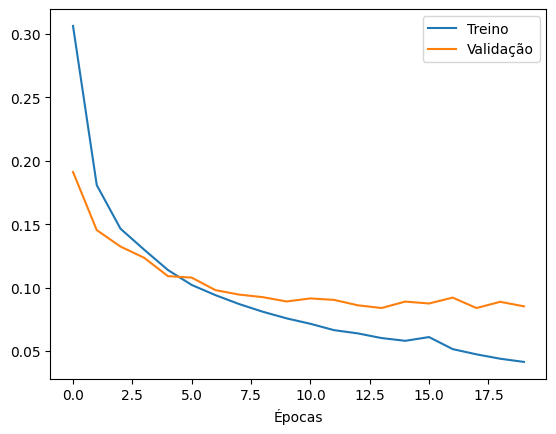

In [9]:
import matplotlib.pyplot as plt

plt.plot(train_loss_all_epoch)
plt.plot(val_loss_all_epoch)
plt.legend(['Treino', 'Validação'])
plt.xlabel('Épocas')

plt.show()

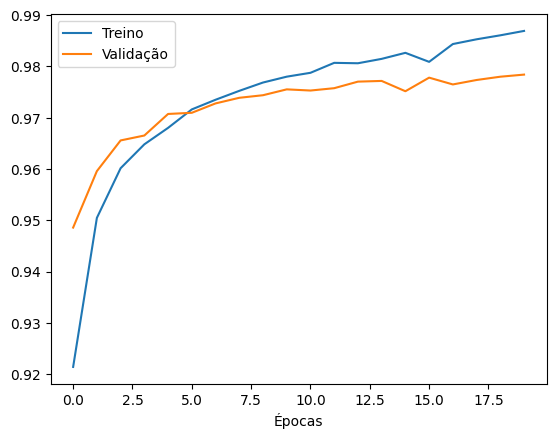

In [10]:
import matplotlib.pyplot as plt

plt.plot(train_accuracy_all_epoch)
plt.plot(val_accuracy_all_epoch)
plt.legend(['Treino', 'Validação'])
plt.xlabel('Épocas')

plt.show()

In [11]:
from sklearn.metrics import classification_report

cnn.train(False)

all_pred = torch.tensor([]).to(device)
all_true = torch.tensor([]).to(device)

for data in test_data:
    x_test,y_test = data
    x_test = x_test.to(device)
    y_test = y_test.to(device)
    y_pred = cnn(x_test)
    y_pred = torch.Tensor.argmax(y_pred, dim=1)
    all_pred = torch.cat((all_pred,y_pred))
    all_true = torch.cat((all_true,y_test))

all_true = all_true.to('cpu')
all_pred = all_pred.to('cpu')
print(classification_report(all_true,all_pred,zero_division=1,digits=5))

              precision    recall  f1-score   support

         0.0    0.98463   0.99332   0.98895     18118
         1.0    0.88276   0.69065   0.77497       556
         2.0    0.94045   0.94890   0.94465      1448
         3.0    0.79412   0.66667   0.72483       162
         4.0    0.98357   0.96766   0.97555      1608

    accuracy                        0.97839     21892
   macro avg    0.91710   0.85344   0.88179     21892
weighted avg    0.97763   0.97839   0.97765     21892



In [13]:
import torch
import torchvision.models as models

saved_model = models.alexnet()
num_ftrs = saved_model.classifier[6].out_features
saved_model.classifier.add_module("7",nn.Linear(num_ftrs, 5))

saved_model.load_state_dict(torch.load('SavedModels/test_model'))

saved_model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [14]:
from sklearn.metrics import classification_report

saved_model.train(False)

all_pred = torch.tensor([]).to(device)
all_true = torch.tensor([]).to(device)

for data in test_data:
    x_test,y_test = data
    x_test = x_test.to(device)
    y_test = y_test.to(device)
    y_pred = saved_model(x_test)
    y_pred = torch.Tensor.argmax(y_pred, dim=1)
    all_pred = torch.cat((all_pred,y_pred))
    all_true = torch.cat((all_true,y_test))

all_true = all_true.to('cpu')
all_pred = all_pred.to('cpu')
print(classification_report(all_true,all_pred,zero_division=1,digits=5))

              precision    recall  f1-score   support

         0.0    0.98371   0.99338   0.98852     18118
         1.0    0.94211   0.64388   0.76496       556
         2.0    0.92891   0.94751   0.93812      1448
         3.0    0.71895   0.67901   0.69841       162
         4.0    0.98235   0.96891   0.97558      1608

    accuracy                        0.97734     21892
   macro avg    0.91121   0.84654   0.87312     21892
weighted avg    0.97697   0.97734   0.97641     21892

